In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from testing.gain_patterns.main import get_tone_ladder_recording

freq_spacing = 2500
freqs = range(15000, 50000, freq_spacing)
tone_length = 1e4

signal = get_tone_ladder_recording(freqs, tone_length)
signal = signal.flatten().astype(np.int32)

signal


   ___  ____  ___  _____  __
  / _ \/ __ \/ _ )/  _/ |/ /
 / , _/ /_/ / _  |/ //    / 
/_/|_|\____/____/___/_/|_/
The wearable echolocator

Notice: not configured as a Robin headset. Export ROBIN_IS_DEVICE=1 to make that happen.


array([-237, -237, -236, ..., -237, -236, -236], dtype=int32)

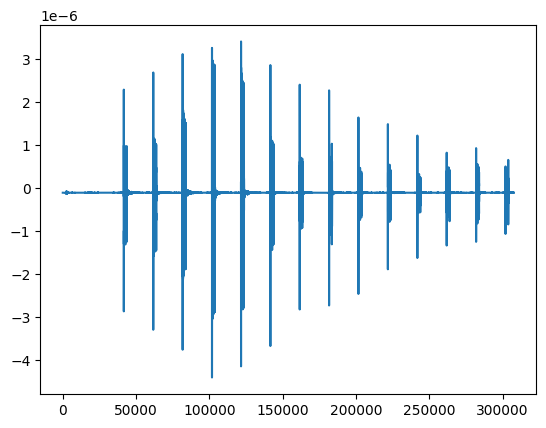

In [3]:
original_dtype = signal.dtype


# Normalization factor based on the maximum value of the input dtype
dtype_max = np.iinfo(original_dtype).max if np.issubdtype(original_dtype, np.integer) else 1.0

# Convert to float32 and normalize
normalized_signal = signal.astype(np.float32) / dtype_max

plt.plot(normalized_signal)

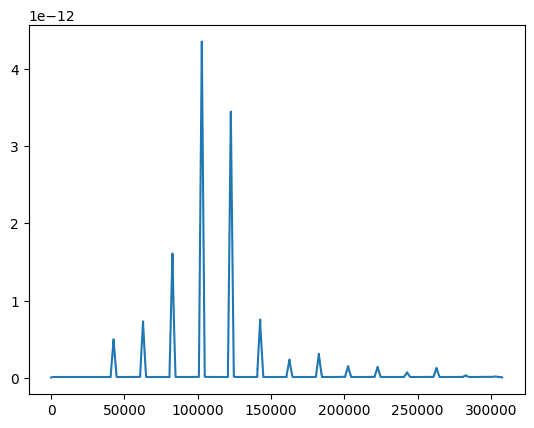

In [4]:
threshold_db = -30
filter_window_length = 2000

# Square each element to get signal power timeseries
power_signal = np.square(normalized_signal)

# Compute threshold power
threshold_power = np.max(power_signal) * 10 ** (threshold_db / 10)

# Apply low-pass filtering on the power signal
window = np.ones(filter_window_length) / filter_window_length
filtered_power_signal = np.convolve(power_signal, window, mode='same')

plt.plot(filtered_power_signal)

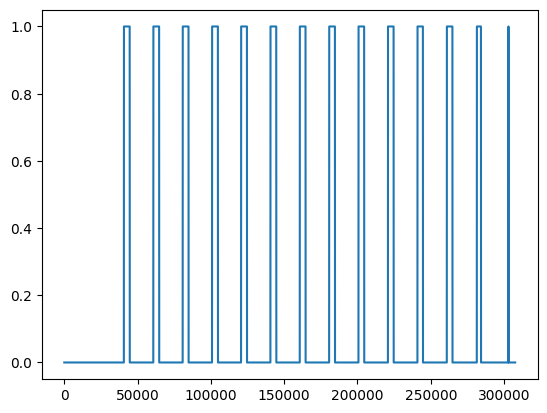

In [5]:
# Map each element to 0 or 1 based on threshold
thresholded_signal = (filtered_power_signal > threshold_power).astype(int)

plt.plot(thresholded_signal)

In [6]:
non_silent_segments = []
start = None
for i, value in enumerate(thresholded_signal):
    if value == 1 and start is None:
        start = i
    elif value == 0 and start is not None:
        segment = normalized_signal[start:i] * dtype_max
        non_silent_segments.append(segment.astype(original_dtype))
        start = None
if start is not None:
    segment = normalized_signal[start:] * dtype_max
    non_silent_segments.append(segment.astype(original_dtype))

(len(freqs), len(non_silent_segments))

(14, 15)

In [7]:
segs_and_idxs = []
for idx, segment in enumerate(non_silent_segments):
    segs_and_idxs.append((segment, idx))
segs_by_length = list(sorted(segs_and_idxs, key=lambda pair: -len(pair[0])))
longest_segs_unsorted = segs_by_length[0:len(freqs)]
tone_segments = [pair[0] for pair in list(sorted(longest_segs_unsorted, key=lambda pair: pair[1]))]

In [8]:
from robin.util import bandpass

powers = {}
for idx, freq in enumerate(freqs):
    segment = tone_segments[idx].astype(np.int32)
    segment = bandpass(segment, freq - freq_spacing / 4, freq + freq_spacing / 4, 192000)
    power = np.sum(segment ** 2) / len(segment)
    powers[freq] = power

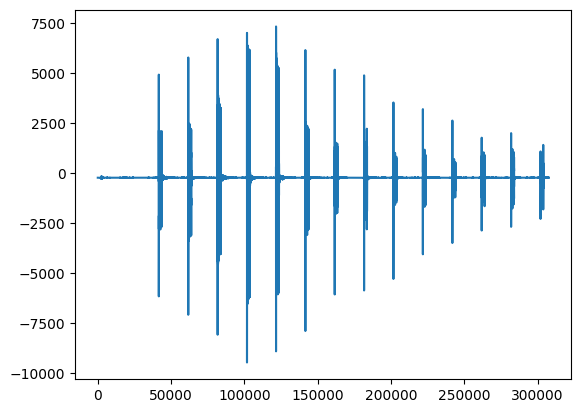

In [9]:
plt.plot(signal)

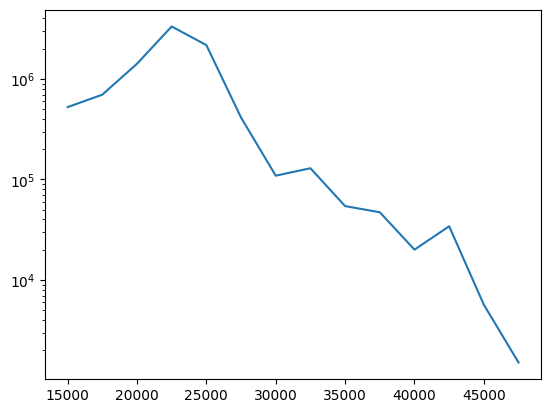

In [10]:
plt.yscale("log")
plt.plot(powers.keys(), powers.values())